# Importation des données

In [16]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)
np.random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

import gensim
from gensim.models import word2vec

import rpy2.robjects as r

In [21]:
nom_dossier = "100k"
gensim_utile = True #True pour le modèle google, False pour le modele ARK

nom_dossier = "ens" 

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')


with open("data/corpus_trie%s.file" %nom_dossier, "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

1348627

On crée index_mot et mot_index

In [27]:
phrases = ens_tweets
words = [item for sublist in phrases for item in sublist]
print(type(words))
with open('data/%s/vocabulary.file' %nom_dossier, "rb") as f:
    vocabulary = pickle.load(f) 
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 31390592
Taille du vocabulaire : 70330


In [28]:
print(fdist.most_common(100))

[('nickname', 1542945), ('de', 1097380), ('lowfrequencyword', 1082919), ('le', 712091), ('est', 589701), ('je', 541570), ('les', 509159), ('c', 493644), ('la', 485258), ('j', 475754), ('à', 463614), ('pas', 453761), ('en', 332771), ('que', 330610), ('un', 301553), ('et', 300208), ('a', 285976), ('ça', 261630), ('il', 249708), ('ai', 246562), ('l', 241270), ('mais', 230924), ('pour', 220047), ('tu', 202209), ('d', 197925), ('on', 195768), ('une', 185405), ('😂', 182836), ('me', 162163), ('ce', 158652), ('😭', 154803), ('qui', 153344), ('t', 144630), ('dans', 133250), ('sur', 132826), ('plus', 132698), ('moi', 123416), ('qu', 122897), ('mon', 121416), ('y', 118672), ('suis', 117578), ('fait', 113295), ('trop', 109829), ('avec', 109023), ('vous', 108423), ('bien', 107295), ('ma', 98729), ('si', 96658), ('tout', 93320), ('va', 88117), ('elle', 88025), ('m', 87131), ('même', 84683), ('faire', 83027), ('bon', 76618), ('quand', 75479), ('ne', 74787), ('toi', 74705), ('merci', 73715), ('mdr', 70

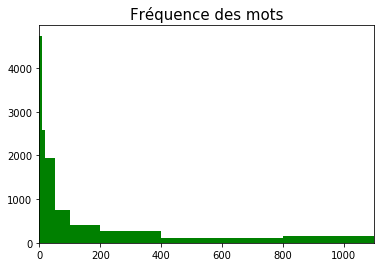

In [8]:
import matplotlib.pyplot as plt
plt.hist(fdist.values(), bins=[0,10,20,50, 100, 200,400,800,max(fdist.values())],color='g') #width=100, range=(0, 50000)
plt.xlim(xmin=0, xmax = 1100)
plt.title('Fréquence des mots', fontsize=15)
plt.show()

# Fonctions générales

## 1. Distances

Pour tester la similarité entre deux mots, on calcule la **similarité cosinus** entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

On peut également calculer la **distance euclidienne** pour comparer les résultats avec ces deux métriques

In [9]:
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

def eucl_distance(u, v):
    return (1/(np.linalg.norm(u/np.dot(u, u)-v/np.dot(v, v)))+1)

Cette fonction permet d'afficher les n mots les plus proche d'un mot (distance cosinus ou euclidienne)

In [10]:
def mot_plus_proche(word, n=10, distance="cos"):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            if distance == "cos":
                word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
            else:
                word_distance[mot] = (eucl_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

Cette fonction permet de calculer la distance entre deux mots. 

In [11]:
def distance_mots(word1,word2, mot_poids, distance="cos"):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        if(distance=="cos"):
            word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
        else:
            word_distance = (eucl_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)

# Evaluer un seul modèle 

Ecrire les bilans ici : https://github.com/AQLT/StatApp/blob/master/Code/Parametres%20lances.md


## 1. Charger le modèle


Paramètres à modifier 

In [25]:
if gensim_utile: # Pour le modèle Google
    # renseigner dans l'ordre : dim, epoch, window, learning_rate
    simul = [50,100,3,0.01] # une seule simulation dans cette partie
    dim = simul[0]
    epoch = simul[1]
    window = simul[2]
    learning_rate = simul[3]
    seed = 1
else: # Pour le modèle ARK (à modifier ultérieurement avec nouveau nommage)
    numero_simulation = 2
    seed = 1
    derniere_epoch = 10 

In [29]:
if gensim_utile: # Pour le modèle Google
    #chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) +"_seed"+ str(seed)
    chemin = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed{}".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:], seed)  
    model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
    py_list = []
    for mot in vocabulary:
         py_list.append(model.wv[mot].tolist())   
    mat_finale = torch.FloatTensor(py_list)
else: # Pour le modèle ARK (à modifier ultérieurement avec nouveau nommage)
    with open('data/%s/Simulation_%i_seed%i/input_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch) , "rb") as f:
        input = pickle.load(f)
    with open('data/%s/Simulation_%i_seed%i/output_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch), "rb") as f:
        output = pickle.load(f)
    mat_finale = (input+output)/2 
    
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

data/ens/gensim/dim50_ep100_w3_lr01_seed1


## 2. Mots les plus proches

In [30]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme","romain"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print('cosinus :',mot_plus_proche(mot,distance = "cos"))
        print('euclidienne :',mot_plus_proche(mot,distance = "eucl"))
        print("\n")

Pour le mot "tweet" (12734 apparitions), les mots les plus proches sont : 
cosinus : [('commentaire', 0.8120738862761055), ('thread', 0.8034873133141094), ('prénom', 0.7921359576750122), ('twit', 0.7883117471212971), ('message', 0.7843599412022436), ('gif', 0.7684524833414121), ('hashtag', 0.7494824495553114), ('sujet', 0.7469473759062351), ('texte', 0.7461472336588743), ('mot', 0.7320564323615006)]
euclidienne : [('thread', 25.283503393406562), ('commentaire', 24.67298694850615), ('prénom', 24.44062751108611), ('message', 24.01051794943361), ('num', 21.925232731284876), ('sujet', 21.735680790558508), ('profil', 21.065805954302053), ('texte', 21.060647493691896), ('mail', 20.699065049110533), ('lien', 20.63259827106755)]


Pour le mot "bonjour" (17043 apparitions), les mots les plus proches sont : 
cosinus : [('bonsoir', 0.9133224755780629), ('bjr', 0.8258046535987295), ('hello', 0.7998790493979635), ('salut', 0.6852745933350016), ('coucou', 0.6713989134021601), ('transmets', 0.6390266

## 3. Réduction de dimension (ACP, TSNE)

### A. Listes de mots utilisées

**Liste 1** correspond à une liste de mot que nous choississons nous-même d'évaluer. 

In [44]:
liste1 = [["poli","courtois","bonjour","salut"],["canapé","fauteuil","table","chaise"],
    ["téléphone","portable","numéro","appel"],["voiture","camion","vélo","train"],
         ["beau","mignon","bg","mannequin"],["docteur","médecin","santé","bobo"],
         ["belle","jolie","mignonne","bellegosse"],["père","papa","daron"],
         ["mère","maman","daronne"],["ol","psg","foot","stade"]]

#liste1 = [["homme","femme", "enfant"],["chien","chat"],
#         ["vanille","chocolat"],
#    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
#    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]

#liste1 = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
#    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
#    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
#    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
#    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
#    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
#    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
#    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
#    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
#    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
#]

**Liste 2** tire au sort une liste de mots regroupés selon leur fréquence d'apparition. 

In [45]:
np.random.seed(1)

mots0_20 = dict()
mots20_100 = dict()
mots100_1000 = dict()
mots1000_max = dict()

for (key, value) in fdist.items():
    if value <= 20 :
        mots0_20[key] = value
    if value > 20 and value <= 100 :
        mots20_100[key] = value
    if value > 100 and value <= 1000 :
        mots100_1000[key] = value        
    if value > 1000 :
        mots1000_max[key] = value


liste_0_20 = list(np.random.choice(list(mots0_20.keys()), size=100))
liste_20_100 = list(np.random.choice(list(mots20_100.keys()), size=100))
liste_100_1000 = list(np.random.choice(list(mots100_1000.keys()), size=100))
liste_1000_max = list(np.random.choice(list(mots1000_max.keys()), size=100))

liste2 = [liste_0_20, liste_20_100, liste_100_1000, liste_1000_max]

### B. ACP

In [46]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))

        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


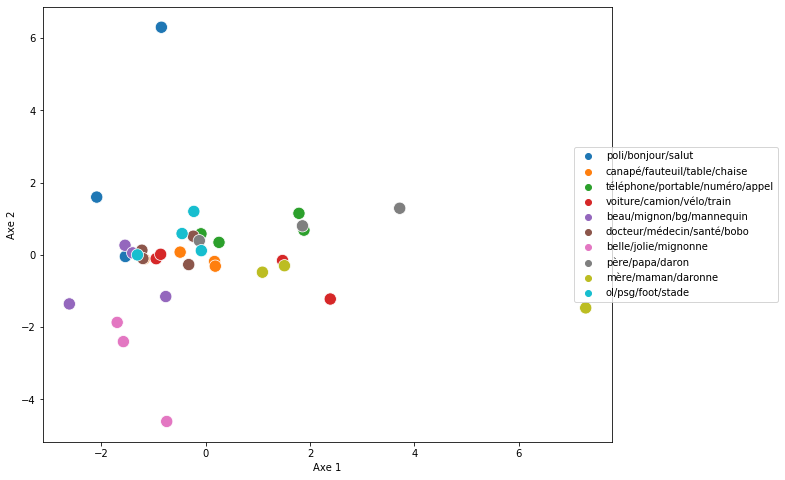

In [47]:
ACP(liste1, statique = True)

In [48]:
ACP(liste1, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [49]:
ACP(liste2, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



## 4. TSNE 

In [50]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')

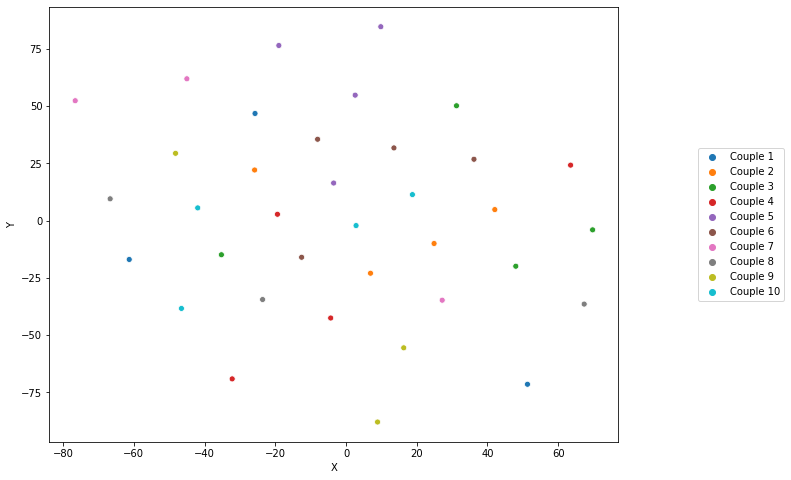

In [51]:
tsne_graph(liste1, statique = True,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?

In [52]:
tsne_graph(liste1, statique = False,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [53]:
tsne_graph(liste2, statique = False,
           nom_couples_explicite = True)#Paramètre ne marche pas : a debuger ?

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



## 5. Human judgement

In [54]:
df_base = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df_base

,word1,word2,corr
0,corde,sourire,0.00
1,midi,ficelle,0.00
2,coq,périple,0.06
3,fruit,fournaise,0.11
4,autographe,rivage,0.00
...,...,...,...
60,coussin,oreiller,3.00
61,cimetière,cimetière,4.00
62,automobile,auto,3.94
63,joyau,bijou,3.22


In [55]:
distance_mots_v = np.vectorize(distance_mots)
df = df_base
df["corr_word2vec_cos"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "cos")
df["corr_word2vec_eucl"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "eucl")
print(len(df))
df = df.dropna()
print(len(df))
df

65
13


,word1,word2,corr,corr_word2vec_cos,corr_word2vec_eucl
0,corde,sourire,0.00,0.861048,1.971783
16,côte,forêt,0.22,0.896572,2.774198
20,garçon,sage,0.29,0.770963,3.267358
23,gars,sorcier,0.44,0.089203,1.803522
28,oiseau,bois,0.06,0.654386,2.053173
33,auto,voyage,0.33,0.531213,2.832017
35,verre,bijou,0.56,0.671575,1.652271
38,frère,gars,2.00,0.635590,6.428527
39,sage,sorcier,0.83,0.862786,2.340675
43,nourriture,fruit,2.78,0.893401,2.865162


In [56]:
#On fait des tests à 5 % pour la distance cosinus
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_cos"])
if p_value > alpha:
    print('Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

print("\n")

#On fait des tests à 5 % pour la distance euclidienne
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_eucl"])
if p_value > alpha:
    print('Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.384 / Valeur de la corrélation : -0.264


Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.590 / Valeur de la corrélation : 0.165


# Evaluer plusieurs modèles 

## 1. Evaluation par le "human judgement"


In [36]:
def corr_modele(chemin, distance="cos", gensimbool = gensim_utile, epoch_max = 50):  
    all_cor = []
    all_p_val = []
    if gensimbool:
        #chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) + dossier
        #chemin = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed{}".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:], seed)  
        isdir = os.path.isdir(chemin)
        if isdir:
            model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
            py_list = []
            for mot in vocabulary:
                py_list.append(model.wv[mot].tolist())   
            mat_finale = torch.FloatTensor(py_list)
            mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
            df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
            df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
            df = df.dropna()
            corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
            all_cor.append(corr)
            all_p_val.append(p_value)
    else:
        isdir = os.path.isdir(chemin)
        if isdir:
            for i in range(epoch_max):
                try:
                    with open('{}/input_{}.file'.format(chemin, i+1), "rb") as f:
                        input = pickle.load(f)
                    with open('{}/output{}.file'.format(chemin, i+1), "rb") as f:
                        output = pickle.load(f)
                    mat_finale = (input+output)/2
                    mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                    df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
                    df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
                    df = df.dropna()
                    corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
                    all_cor.append(corr)
                    all_p_val.append(p_value)
                except OSError:
                    break;     
        
    return([all_cor, all_p_val]);

In [166]:
def tableau_corr_hji(dim = "\d*", epoch = "\d*", window = "\d*",
                     learning_rate = "\d*", seed = "\d*",
                     distance="cos", index = "seed", gensimbool = gensim_utile):    
    if(isinstance(learning_rate, float)):
        learning_rate = str(learning_rate)[2:]
    if(isinstance(dim, list)):
        dim = r.r['paste0']("(",r.r['paste0']("(",dim,")",collapse = "|"),")")[0]
    if(isinstance(epoch, list)):
        epoch = r.r['paste0']("(",r.r['paste0']("(",epoch,")",collapse = "|"),")")[0]
    if(isinstance(window, list)):
        window = r.r['paste0']("(",r.r['paste0']("(",window,")",collapse = "|"),")")[0]
    if(isinstance(learning_rate, list)):
        learning_rate = [str(lr)[2:] if isinstance(lr, float) else lr for lr in learning_rate]
        learning_rate = r.r['paste0']("(",r.r['paste0']("(",learning_rate,")",collapse = "|"),")")[0]
    if(isinstance(seed, list)):
        seed = r.r['paste0']("(",r.r['paste0']("(",seed,")",collapse = "|"),")")[0]

    requete_regexp = 'dim{}_ep{}_w{}_lr{}_seed{}'.format(dim, epoch, window, learning_rate, seed)
    if gensimbool:
        gensim_st = "gensim/"
    else:
        gensim_st = ""
    dossiers = r.r['list.files'](path = 'data/{}/{}'.format(nom_dossier, gensim_st),
                      pattern = requete_regexp)
    dossiers = [dossiers[i] for i in range(len(dossiers))]
    #dossiers = r.r['paste0']('data/{}/{}'.format(nom_dossier, gensim_st),dossiers)
    
    resultats = []
    nom_cols = dossiers

    for dossier in dossiers:
        #nom_cols.append( "dim{}_ep{}_lr{}_w{}".format(simul[0], simul[1], simul[2], str(simul[3])[2:]))
        #print(nom_cols)
        resultats.append(corr_modele(chemin = 'data/{}/{}{}'.format(nom_dossier, gensim_st, dossier), 
                                 distance= distance,gensimbool = gensimbool))
    max_len = max([len(x[0]) for x in resultats])
    for i in range(len(resultats)):
        if(len(resultats[i][0])<max_len):
            resultats[i][0] = resultats[i][0] +[np.nan]*(max_len - len(resultats[i][0]))
            resultats[i][1] = resultats[i][1] +[np.nan]*(max_len - len(resultats[i][1]))
    #nom_lignes = [re.sub('_seed', 'Seed ', d) if d != "" else "Pas de seed" for d in dossiers ]
    #nom_lignes = ["Seed " + str(s) for s in seeds]
    dossiers_sep = [string.split('_') for string in dossiers]
    all_dim = [r.r['grep']("^dim", x, value = True)[0] for x in dossiers_sep]
    all_ep = [r.r['grep']("^ep", x, value = True)[0] for x in dossiers_sep]
    all_w = [r.r['grep']("^w", x, value = True)[0] for x in dossiers_sep]
    all_lr = [r.r['grep']("^lr", x, value = True)[0] for x in dossiers_sep]
    all_seed = [r.r['grep']("^seed", x, value = True)[0] for x in dossiers_sep]
    all_name = [all_dim, all_ep, all_w, all_lr, all_seed]
    correspondance = {'dim': 0,
                  'epoch': 1,
                  'window': 2,
                  'learning_rate': 3,
                 'seed': 4}
    if not isinstance(index, list):
        index = [index]
    index_num = [correspondance[i] for i in index]
    indexs = [all_name[i] for i in [0,1,2,3,4] if i in index_num ]
    column = [all_name[i] for i in [0,1,2,3,4] if i not in index_num]
    lignes = list(map("_".join, zip(*indexs)))
    colonnes = list(map("_".join, zip(*column)))
    pivot_df = pd.DataFrame({'lignes': lignes,
                  'colonnes': colonnes})
    
    all_cor = pd.DataFrame([elem[0] for elem in resultats])
    all_p_val = pd.DataFrame([elem[1] for elem in resultats])
    all_cor.columns = all_p_val.columns = ["values"]


    all_cor = pd.concat([pivot_df, all_cor], axis=1)
    all_cor = all_cor.pivot(index = "lignes", columns = "colonnes", values = 'values')
    all_p_val = pd.concat([pivot_df, all_p_val], axis=1)
    all_p_val = all_p_val.pivot(index = "lignes", columns = "colonnes", values = 'values')
    return([all_cor, all_p_val])

In [168]:
print(tableau_corr_hji(dim = 50, learning_rate = [0.01,0.02], window = 5, epoch = 100)[0])
print(tableau_corr_hji(dim = 50, learning_rate = [0.01,0.02], window = 5, epoch = 100,
                      index = "learning_rate")[0])

colonnes  dim50_ep100_w5_lr01  dim50_ep100_w5_lr02
lignes                                            
seed1                0.440860             0.497009
seed10               0.451158             0.437048
seed15               0.454353             0.499904
seed20               0.437048             0.474907
seed25               0.434920             0.454534
seed5                0.441876             0.495642
colonnes  dim50_ep100_w5_seed1  dim50_ep100_w5_seed10  dim50_ep100_w5_seed15  \
lignes                                                                         
lr01                  0.440860               0.451158               0.454353   
lr02                  0.497009               0.437048               0.499904   

colonnes  dim50_ep100_w5_seed20  dim50_ep100_w5_seed25  dim50_ep100_w5_seed5  
lignes                                                                        
lr01                   0.437048               0.434920              0.441876  
lr02                   0.474907   

In [50]:
seeds = [1, 5, 10, 15, 20, 25]

resultats_hji_cos = tableau_corr_hji(simuls, seeds, distance = "cos")
all_cor_cos = resultats_hji_cos[0]
all_p_val_cos = resultats_hji_cos[1]
all_cor_export_cos = round(all_cor_cos, 3).dropna()
print(all_cor_export_cos)


resultats_hji_eucl = tableau_corr_hji(simuls, seeds, distance = "eucl")
all_cor_eucl = resultats_hji_eucl[0]
all_p_val_eucl = resultats_hji_eucl[1]
all_cor_export_eucl = round(all_cor_eucl, 3).dropna()
print(all_cor_export_eucl)

['dim20_ep10_lr01_w3']
['dim20_ep10_lr01_w3', 'dim50_ep10_lr01_w3']


ValueError: Shape of passed values is (12, 1), indices imply (6, 2)

In [44]:
##Il faut installer pandas 1.0 et tabulate
print(all_cor_export_cos.to_markdown())
print("\nDistance euclidienne :\n")
print(all_cor_export_eucl.to_markdown())

|         |   Epoch 1 |
|:--------|----------:|
| Seed 1  |    -0.093 |
| Seed 5  |    -0.203 |
| Seed 10 |    -0.203 |
| Seed 15 |    -0.071 |
| Seed 20 |    -0.231 |
| Seed 25 |    -0.33  |

Distance euclidienne :

|         |   Epoch 1 |
|:--------|----------:|
| Seed 1  |     0.242 |
| Seed 5  |     0.121 |
| Seed 10 |     0.181 |
| Seed 15 |     0.297 |
| Seed 20 |     0.313 |
| Seed 25 |     0.28  |


In [48]:
from matplotlib.lines import Line2D

def intervalles_confiance (simulations, distance = "cos"):
    colors = sns.color_palette("hls", 6)
    fig = plt.figure(figsize = (12,6))    
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    ax.set_xlim(-0.2,len(simulations)-1+.2)
   # ax.set_ylim(-0.5,0.6) # seulement si besoin pour faire des graph comparables
    for i in range(len(simulations)):
        corr = tableau_corr_hji(dossiers, distance = distance, numero_simulation = simulations[i])[0]
        corr_values = corr.iloc[:,-1].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        print(moy)
        icm = moy - 1.96 * ec
        icp = moy + 1.96 * ec
        ax.errorbar(i, moy, yerr=1.96 * ec,ecolor = "black", alpha = 0.5) 
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100) 
        ax.errorbar(i, moy, xerr=0.1, ecolor = "black", alpha= 0.5)
        
    ax.set_xticks(list(range(len(simulations))))
    #ax.set_xticklabels(["Simul. n°%i" %simul[i] for i in list(range(len(simul)))])
    ax.set_xticklabels(["lr=0.01\n w=3\n e=10","lr=0.01\n w=4\n e=10","lr=0.01\n w=5\n e=10",
                        "lr=0.02\n w=3\n e=10","lr=0.02\n w=4\n e=10","lr=0.02\n w=5\n e=10",
                        "lr=0.01\n w=3\n e=100","lr=0.01\n w=4\n e=100","lr=0.01\n w=5\n e=100",
                        "lr=0.02\n w=3\n e=100","lr=0.02\n w=4\n e=100","lr=0.02\n w=5\n e=100"])
    plt.ylabel("Corrélation entre la distance " + distance + " et le l'indice de jugement humain")
    plt.xlabel("Simulation avec "+ nom_dossier +" tweets")
    custom_lines=[]
    for i in range(len(colors)):
        custom_lines.append(Line2D([0], [0], marker='o', color='w',
                                   label='Scatter',markerfacecolor=colors[i], markersize=10))
    ax.legend(custom_lines, [string[1:] for string in dossiers])

In [49]:
dossiers = ["_seed1", "_seed5", "_seed10", "_seed15", "_seed20", "_seed25"]
#simul = [2,3,4,9,13,14]
simul = [1,2,3,4,5,6,7,8,9,10,11,12]

-0.1886446886446886
-0.20238095238095236
-0.1858974358974359
0.3095238095238095
0.24267399267399267
0.10256410256410257
0.4047619047619047
0.4523809523809524
0.41483516483516486
0.4551282051282051
0.43956043956043955
0.4166666666666667


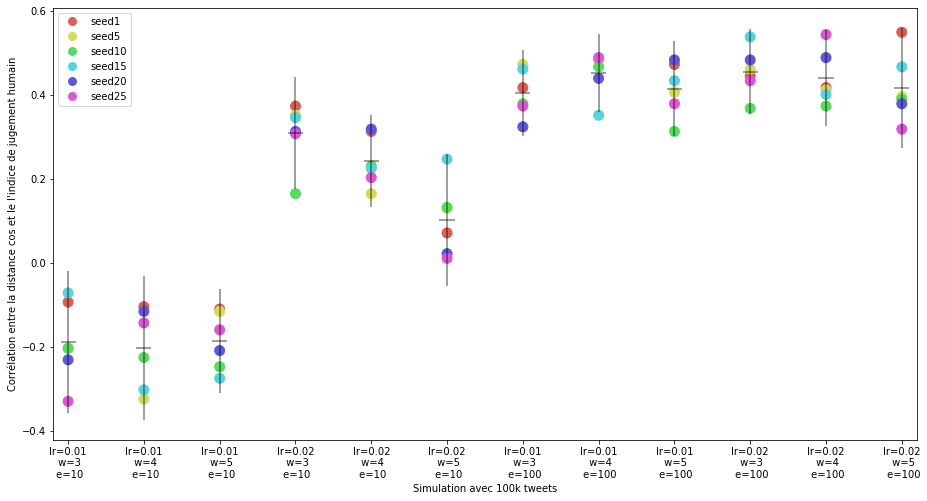

In [50]:
intervalles_confiance(simul, "cos")

0.23901098901098905
0.2014652014652015
0.20421245421245424
0.3708791208791209
0.30494505494505497
0.21978021978021978
0.4084249084249085
0.3727106227106227
0.3388278388278388
0.4294871794871795
0.4194139194139194
0.3626373626373626


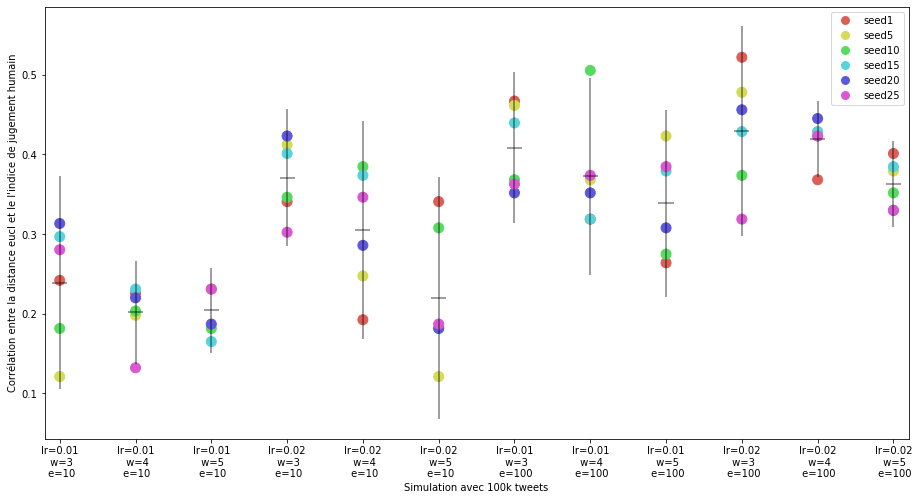

In [51]:
intervalles_confiance(simul, "eucl")

0.03296703296703297
-0.010989010989010985
-0.022893772893772892
0.2591575091575091
0.326007326007326
0.2802197802197802
0.3836996336996337
0.3965201465201465
0.4276556776556777
0.3452380952380952
0.3717948717948718
0.3534798534798535


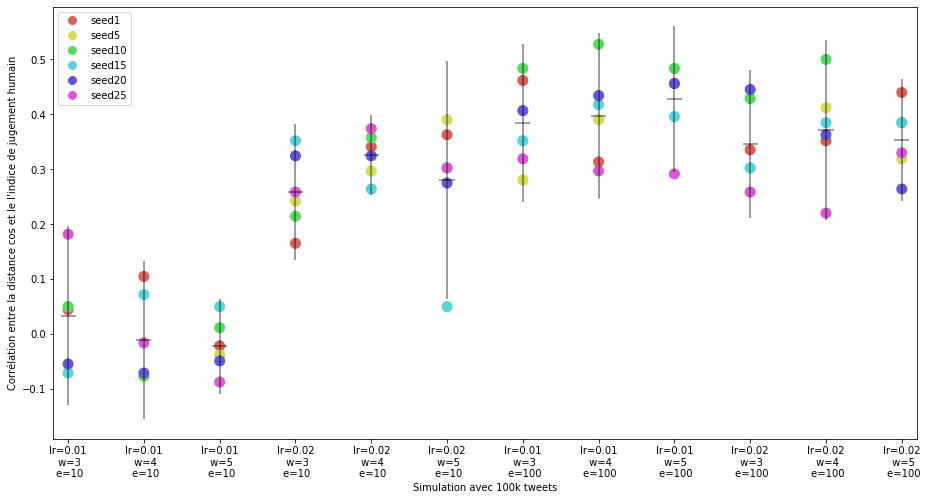

In [25]:
simul2 = [13,14,15,16,17,18,19,20,21,22,23,24]
intervalles_confiance(simul2, "cos")

-0.30036630036630035
-0.26373626373626374
-0.2738095238095238
-0.27930402930402926
-0.2371794871794872
-0.25366300366300365
-0.2371794871794872
-0.2353479853479854
-0.2564102564102564
-0.2692307692307693
-0.2490842490842491
-0.24450549450549453


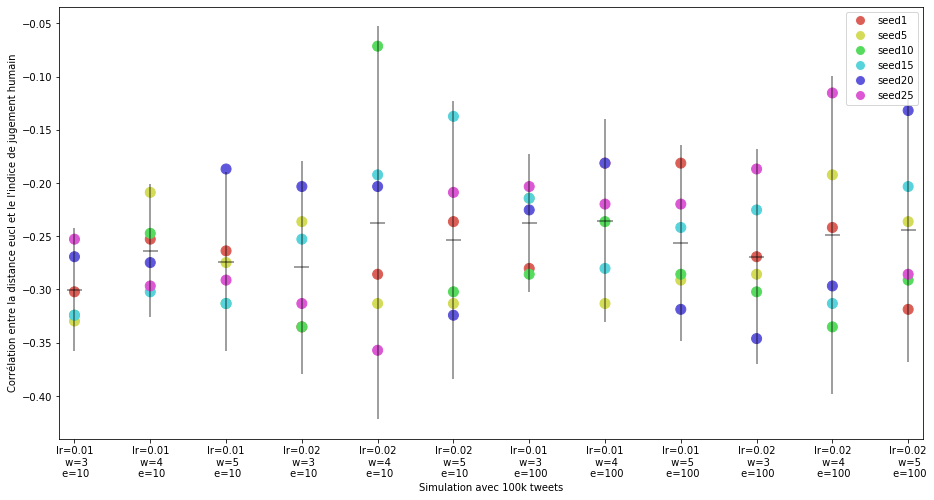

In [26]:
intervalles_confiance(simul2, "eucl")

Fonction Romain provisoire pour tests de représentations graphiques. 

-0.1886446886446886
0.03296703296703297
-0.20238095238095236
-0.010989010989010985
-0.1858974358974359
-0.022893772893772892
0.3095238095238095
0.2591575091575091
0.24267399267399267
0.326007326007326
0.10256410256410257
0.2802197802197802
0.4047619047619047
0.3836996336996337
0.4523809523809524
0.3965201465201465
0.41483516483516486
0.4276556776556777
0.4551282051282051
0.3452380952380952
0.43956043956043955
0.3717948717948718
0.4166666666666667
0.3534798534798535


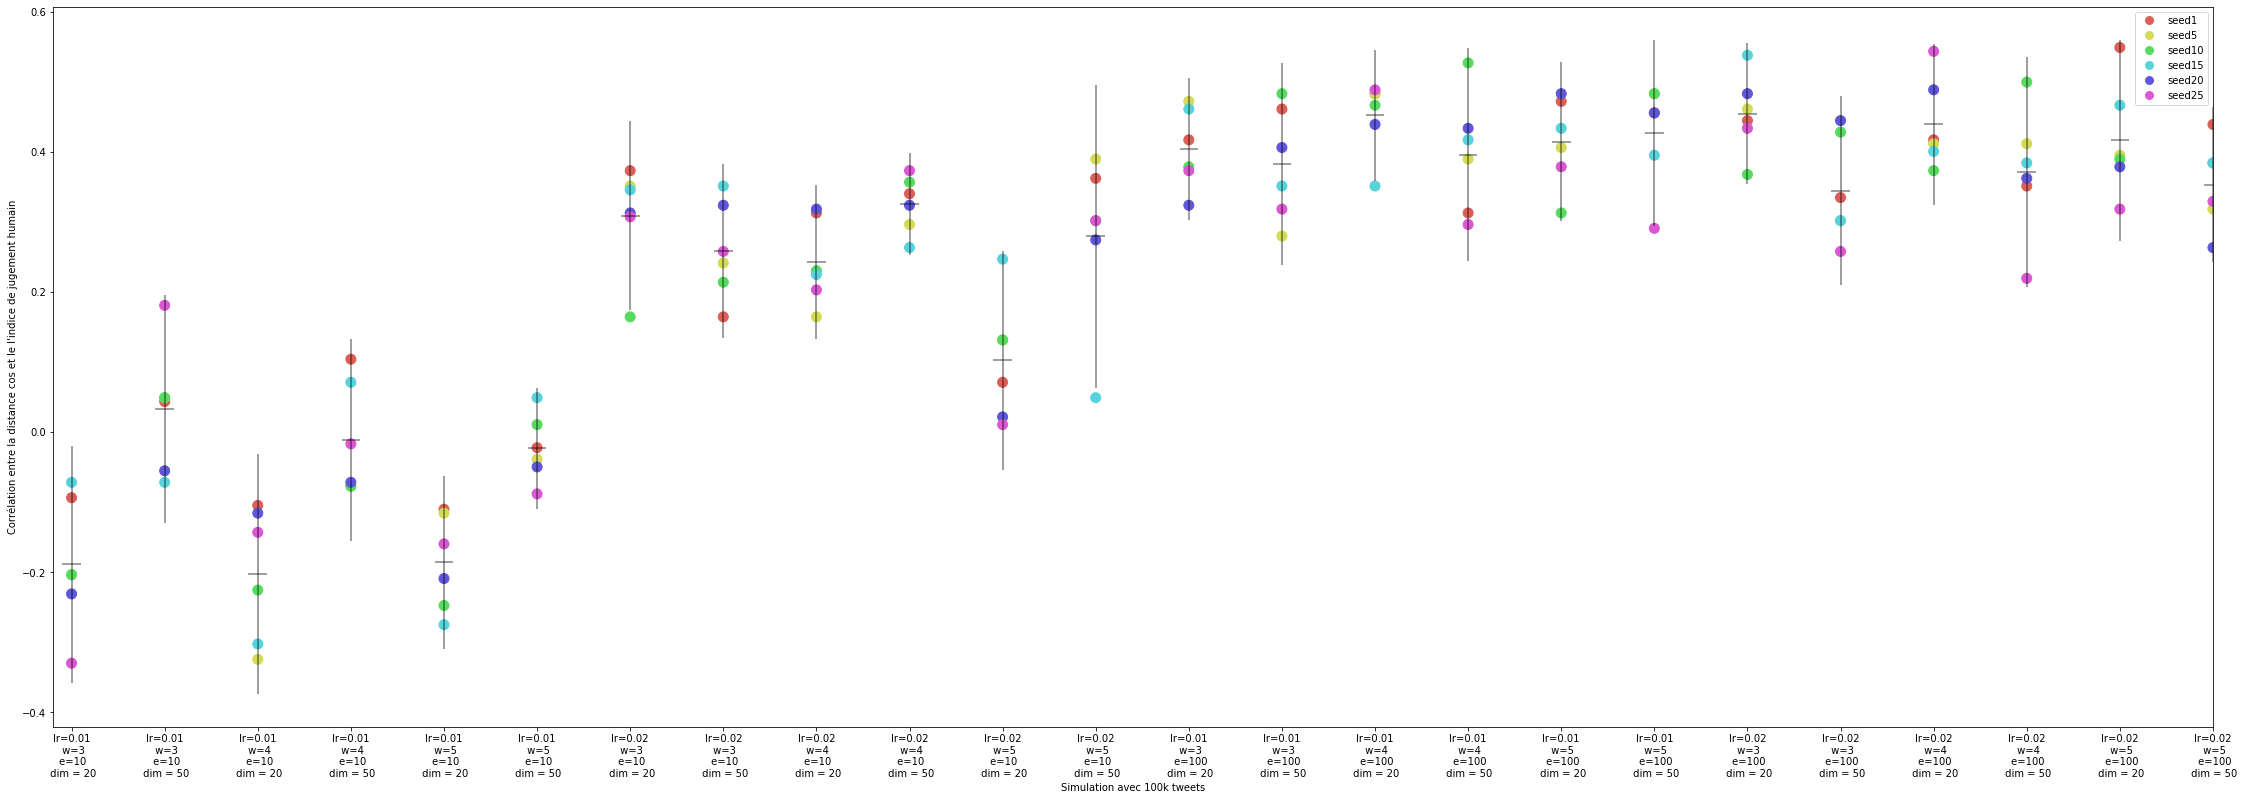

In [32]:
simul3 = [1,13,2,14,3,15,4,16,5,17,6,18,7,19,8,20,9,21,10,22,11,23,12,24]
def intervalles_confiance2(simulations, distance = "cos"):
    colors = sns.color_palette("hls", 6)
    fig = plt.figure(figsize = (30,10))    
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    ax.set_xlim(-0.2,len(simulations)-1+.2)
   # ax.set_ylim(-0.5,0.6) # seulement si besoin pour faire des graph comparables
    for i in range(len(simulations)):
        corr = tableau_corr_hji(dossiers, distance = distance, numero_simulation = simulations[i])[0]
        corr_values = corr.iloc[:,-1].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        print(moy)
        icm = moy - 1.96 * ec
        icp = moy + 1.96 * ec
        ax.errorbar(i, moy, yerr=1.96 * ec,ecolor = "black", alpha = 0.5) 
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100) 
        ax.errorbar(i, moy, xerr=0.1, ecolor = "black", alpha= 0.5)
        
    ax.set_xticks(list(range(len(simulations))))
    #ax.set_xticklabels(["Simul. n°%i" %simul[i] for i in list(range(len(simul)))])
    ax.set_xticklabels(["lr=0.01\n w=3\n e=10\n dim = 20","lr=0.01\n w=3\n e=10\n dim = 50",
                        "lr=0.01\n w=4\n e=10\n dim = 20","lr=0.01\n w=4\n e=10\n dim = 50",
                        "lr=0.01\n w=5\n e=10\n dim = 20","lr=0.01\n w=5\n e=10\n dim = 50",
                        "lr=0.02\n w=3\n e=10\n dim = 20","lr=0.02\n w=3\n e=10\n dim = 50",
                        "lr=0.02\n w=4\n e=10\n dim = 20","lr=0.02\n w=4\n e=10\n dim = 50",
                        "lr=0.02\n w=5\n e=10\n dim = 20","lr=0.02\n w=5\n e=10\n dim = 50",
                        "lr=0.01\n w=3\n e=100\n dim = 20","lr=0.01\n w=3\n e=100\n dim = 50",
                        "lr=0.01\n w=4\n e=100\n dim = 20","lr=0.01\n w=4\n e=100\n dim = 50",
                        "lr=0.01\n w=5\n e=100\n dim = 20","lr=0.01\n w=5\n e=100\n dim = 50",
                        "lr=0.02\n w=3\n e=100\n dim = 20","lr=0.02\n w=3\n e=100\n dim = 50",
                        "lr=0.02\n w=4\n e=100\n dim = 20","lr=0.02\n w=4\n e=100\n dim = 50",
                        "lr=0.02\n w=5\n e=100\n dim = 20","lr=0.02\n w=5\n e=100\n dim = 50"
                       ])
    plt.ylabel("Corrélation entre la distance " + distance + " et le l'indice de jugement humain")
    plt.xlabel("Simulation avec "+ nom_dossier +" tweets")
    custom_lines=[]
    for i in range(len(colors)):
        custom_lines.append(Line2D([0], [0], marker='o', color='w',
                                   label='Scatter',markerfacecolor=colors[i], markersize=10))
    ax.legend(custom_lines, [string[1:] for string in dossiers])
intervalles_confiance2(simul3, "cos")